In [15]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import re
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

In [16]:
data = pd.read_csv("time-series-datasets\monthly-beer-production-in-austr.csv")#Electric_Production  monthly-beer-production-in-austr

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 2 columns):
Month                      476 non-null object
Monthly beer production    476 non-null float64
dtypes: float64(1), object(1)
memory usage: 7.6+ KB


In [18]:
data.head()

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


In [19]:
col = "Monthly beer production"#"IPG2211A2N" #"Monthly beer production"#"IPG2211A2N" 
data = data.rename(columns = {"Month": "Date"})#{"DATE": "Date"})

data.Date = pd.to_datetime(data.Date, format = "%Y-%m")#"%m/%d/%Y")
data.index = data.Date
data = data.drop("Date", axis = 1)
data[col] = data[col].astype(float)
time_data = data[col]

In [20]:
data.head()

,Monthly beer production
Date,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9


# Check the stationarity

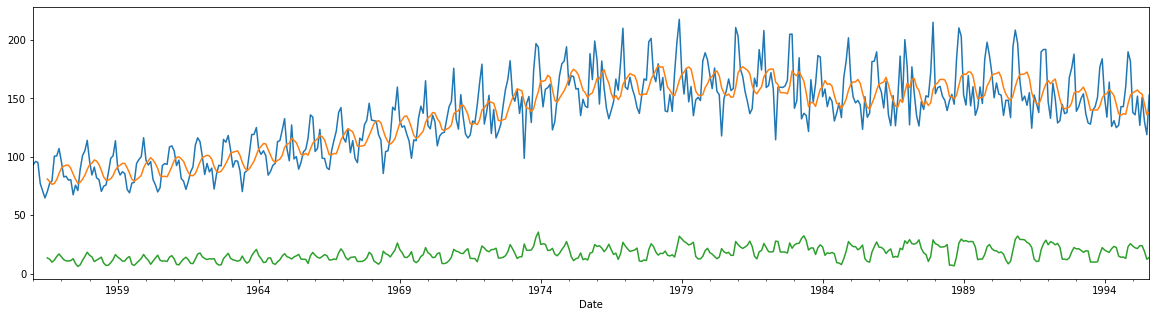

In [21]:
time_data = data[col]
plt.figure(figsize = (20,5))

# draw average
average = time_data.rolling(window = 7, center= False).mean()
time_data_avg = average.dropna()

std = time_data.rolling(window = 7, center= False).std()
time_data_std = std.dropna()

time_data.plot()
time_data_avg.plot()
time_data_std.plot()

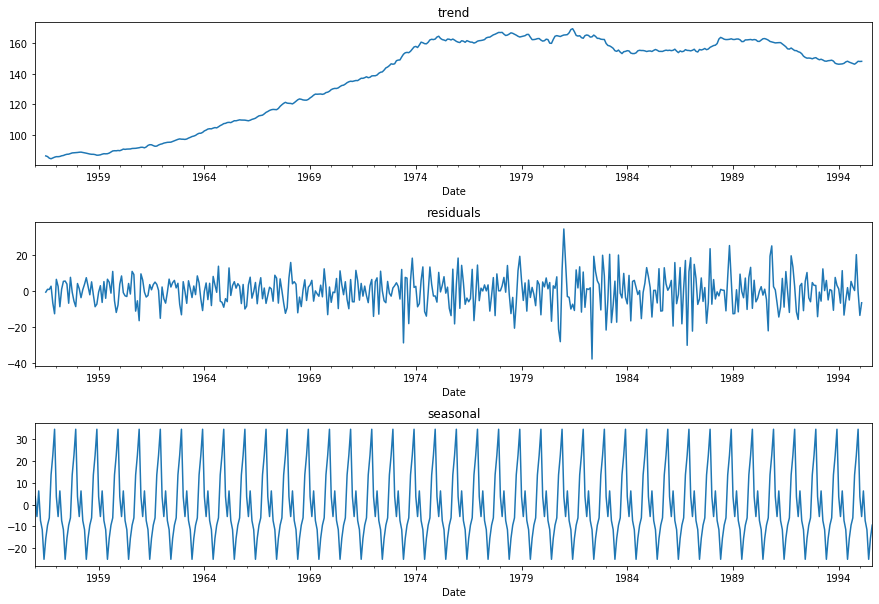

In [22]:
res = seasonal_decompose(time_data)

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,10))
res.trend.plot(ax=ax1, title = "trend")
res.resid.plot(ax=ax2, title = "residuals")
res.seasonal.plot(ax=ax3, title = "seasonal")
plt.subplots_adjust(hspace = 0.4)
plt.show()

## ADF (Augmented Dickey Fuller) Test
The Dickey Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. The null and alternate hypothesis of this test are:

#### Null Hypothesis: The series has a unit root (value of a =1) (non-stationary)

#### Alternate Hypothesis: The series has no unit root. (statonary)

Test for stationarity: If the test statistic is less than the critical value, we can reject the null hypothesis (aka the series is stationary). When the test statistic is greater than the critical value, we fail to reject the null hypothesis (which means the series is not stationary).

In [23]:
dftest = adfuller(time_data, autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                  -2.282661
p-value                          0.177621
#Lags Used                      17.000000
Number of Observations Used    458.000000
Critical Value (1%)             -3.444709
Critical Value (5%)             -2.867871
Critical Value (10%)            -2.570142
dtype: float64


## KPSS (Kwiatkowski-Phillips-Schmidt-Shin) Test
The null and alternate hypothesis for the KPSS test are opposite that of the ADF test, which often creates confusion.

The authors of the KPSS test have defined the null hypothesis as the process is trend stationary, to an alternate hypothesis of a unit root series.

#### Null Hypothesis: The process is trend stationary.

#### Alternate Hypothesis: The series has a unit root (series is not stationary).

Test for stationarity: If the test statistic is greater than the critical value, we reject the null hypothesis (series is not stationary). If the test statistic is less than the critical value, if fail to reject the null hypothesis (series is stationary). 

In [24]:
kpsstest = kpss(time_data, regression='c')
kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
for key,value in kpsstest[3].items():
    kpss_output['Critical Value (%s)'%key] = value
print (kpss_output)

Test Statistic            2.035738
p-value                   0.010000
Lags Used                18.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


d:\it\anaconda3\envs\jsp\lib\site-packages\statsmodels\tsa\stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
d:\it\anaconda3\envs\jsp\lib\site-packages\statsmodels\tsa\stattools.py:1708: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


Case 1: Both tests conclude that the series is not stationary -> series is not stationary

Case 2: Both tests conclude that the series is stationary -> series is stationary

Case 3: KPSS = stationary and ADF = not stationary  -> trend stationary, remove the trend to make series strict stationary

Case 4: KPSS = not stationary and ADF = stationary -> difference stationary, use differencing to make series stationary

# Theory about p, d, q parameters for ARIMA

<img src="arima.jpg" width="400">
<img src="d_param.jpeg" width="400">
<img src="pq_param.jpeg" width="400">

# Make task stationary

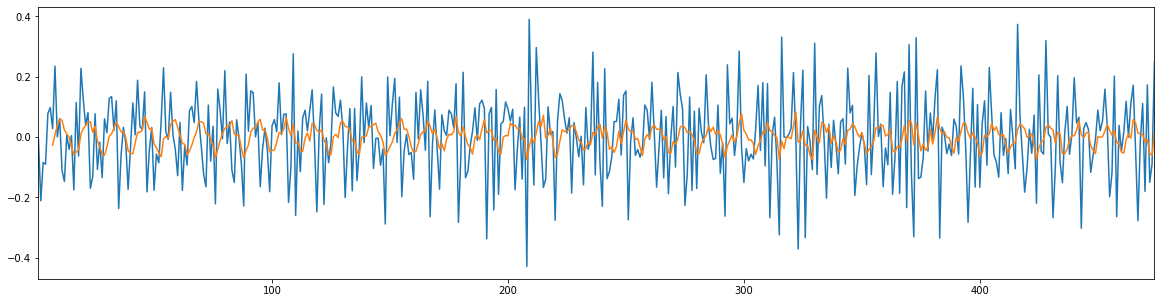

In [25]:
time_data = data[col]
log_time_data = np.log(time_data) ### 1 step
d = 1# 0 or 1
time_data = np.diff(log_time_data, n = d)    ### 2 step
time_data = pd.Series(time_data)
plt.figure(figsize = (20,5))

# draw average
average = time_data.rolling(window = 7, center= False).mean()
time_data_avg = average.dropna()

# draw std
std = time_data.rolling(window = 7, center= False).std()
time_data_std = std.dropna()

time_data = time_data.dropna()

time_data_dates = pd.Series(time_data.values, index = log_time_data[d:].index)

time_data[d:].plot()
time_data_avg[d:].plot()
#time_data_std[d:].plot()
plt.show()

## Split test/train

In [26]:
start = 450 # breaking point beetween the train|test

## Find p, q for ARIMA

In [27]:
# ACF and PACF plots
lag = 5
lag_pacf = pacf(time_data[:start], nlags=lag, method='ols')
lag_acf = acf(time_data[:start], nlags=lag)

d:\it\anaconda3\envs\jsp\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


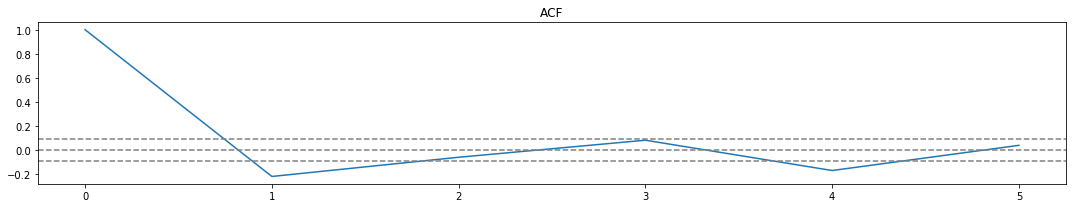

In [28]:
plt.figure(figsize=(15,3))
plt.plot(lag_acf)

plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(time_data[:start])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(time_data[:start])),linestyle='--',color='gray')
plt.title('ACF')
plt.tight_layout()
plt.show()

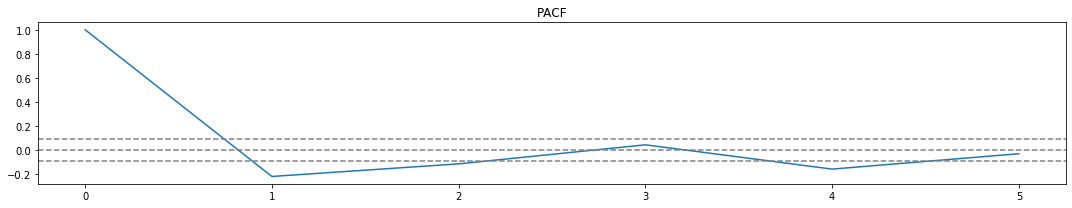

In [29]:
plt.figure(figsize=(15,3))
plt.plot(lag_pacf)

plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(time_data[:start])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(time_data[:start])),linestyle='--',color='gray')
plt.title('PACF')
plt.tight_layout()
plt.show()

### Choose p and q according to the above plots: the point where the curve intersects the line for the first time
<img src="pq_find.png" width="400">

In [30]:
q = 1 # from ACF graph MA # if = 0, we use AR model 
p = 1 # from PACF graph AR # if = 0, we use MA model

# ARIMA tests

d:\it\anaconda3\envs\jsp\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
d:\it\anaconda3\envs\jsp\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


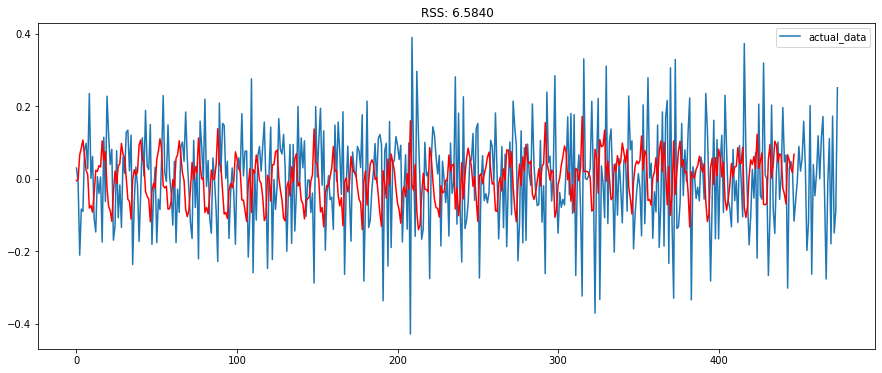

In [31]:
model = ARIMA(log_time_data[:start], order=(p, d, q))  
results_ARIMA = model.fit()

plt.figure(figsize=(15,6))
plt.plot(time_data_dates.values, label='actual_data')
plt.plot(results_ARIMA.fittedvalues[1:].values, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-time_data_dates[d:start]).dropna()**2))
plt.legend(loc='best')
plt.show()

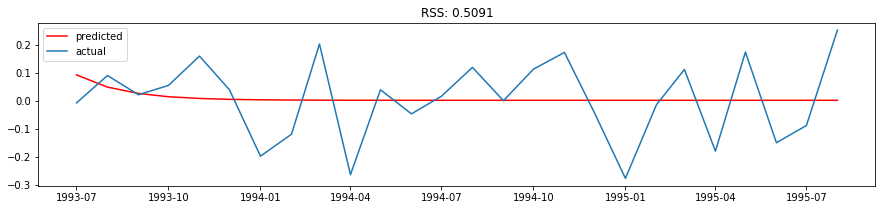

In [32]:
end = len(time_data)
forecast = results_ARIMA.predict(start = start, end = end+d-1)
forecast = forecast.dropna()

plt.figure(figsize=(15,3))
plt.plot(forecast, color='red', label='predicted')
plt.legend(loc='best')
plt.plot(time_data_dates[start-d:end], label='actual')
plt.title('RSS: %.4f'% sum((forecast-time_data_dates[start-d:end]).dropna()**2))
plt.legend(loc='best')
plt.show()

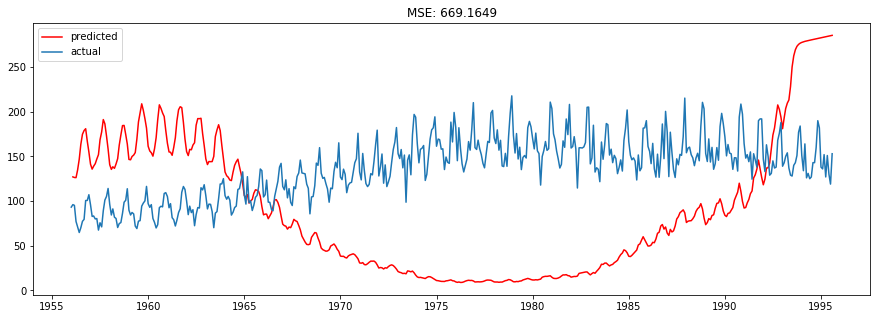

In [33]:
forecast_full = pd.Series(results_ARIMA.fittedvalues.append(forecast))

if d == 1:
    # add the first element of actual data  
    forecast_full = pd.concat([pd.Series([log_time_data[0]], index = [data.index[0]]), forecast_full])# add the first element of actual data
    forecast_full = forecast_full.cumsum()
forecast_full = np.exp(forecast_full)


plt.figure(figsize=(15,5))
plt.plot(forecast_full[d:], color='red', label='predicted')
plt.legend(loc='best')
plt.plot(data[col], label='actual')
plt.title('MSE: %.4f'% np.sqrt(sum((forecast_full[start:end].values - data[col][start:end].values)**2)))
plt.legend(loc='best')
plt.show()

In [34]:
results_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ARIMA Model Results                                 
=====================================================================================
Dep. Variable:     D.Monthly beer production   No. Observations:                  449
Model:                        ARIMA(1, 1, 1)   Log Likelihood                 310.698
Method:                              css-mle   S.D. of innovations              0.121
Date:                       Mon, 19 Aug 2019   AIC                           -613.395
Time:                               12:14:33   BIC                           -596.967
Sample:                           02-01-1956   HQIC                          -606.920
                                - 06-01-1993                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               0.0014      0.001      2.513      0.012       0.000       0.002
ar.L1.D.Monthly beer production     0.5197      0.043     12.062      0.000       0.435       0.604
ma.L1.D.Monthly beer production    -0.9562      0.011    -90.983      0.000      -0.977      -0.936
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.9243           +0.0000j            1.9243            0.0000
MA.1            1.0458           +0.0000j            1.0458            0.0000
-----------------------------------------------------------------------------
"""